# Prototype YOLO Data Generator

In [1]:
import os

import cv2
import numpy as np
import xml.etree.ElementTree as ET
import tensorflow as tf
from sklearn.cluster import KMeans

import random

In [2]:
# Avoid out of memory errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## Configuration

In [3]:
CFG = {
    "dataset_dir":  "D:\Github Public\DATASET MANAGER\ObjectDetection_SIMPLE",
    "image_size": (416, 416),
    "anchor": 3,
    "batch": 8,
    "annotation_dict": {"Face": 0,"Oppai": 1}, 
}

## Class declaration

In [4]:
class YOLOv3Augmentation:
    def __init__(self, image_size, translate_range, rotation_range):
        self.__image_size = image_size
        self.__translate_range = translate_range
        self.__rotation_range = rotation_range

    @tf.autograph.experimental.do_not_convert
    def horizontal_flip(self, image, annotation_list):
        # Flip image
        image = cv2.flip(image, 1)  # Flip horizontally

        # Update annotation list
        updated_annotation_list = []

        for annotation in annotation_list:
            for class_idx, xmin, ymin, xmax, ymax in [annotation]:
                # Invert the x-coordinates
                xmin, xmax = 1 - xmax, 1 - xmin  
                
                # Create a new annotation tuple
                new_annotation = (class_idx, xmin, ymin, xmax, ymax)
                updated_annotation_list.append(new_annotation)
        
        return tf.convert_to_tensor(image), tf.convert_to_tensor(updated_annotation_list)
    
    @tf.autograph.experimental.do_not_convert
    def vertical_flip(self, image, annotation_list):
        # Flip image
        image = cv2.flip(image, 0)  # Flip vertically

        # Update annotation list
        updated_annotation_list = []

        for annotation in annotation_list:
            for class_idx, xmin, ymin, xmax, ymax in [annotation]:
                # Invert the x-coordinates
                ymin, ymax = 1 - ymax, 1 - ymin  
                
                # Create a new annotation tuple
                new_annotation = (class_idx, xmin, ymin, xmax, ymax)
                updated_annotation_list.append(new_annotation)
        
        return tf.convert_to_tensor(image), tf.convert_to_tensor(updated_annotation_list)
    
    @tf.autograph.experimental.do_not_convert
    def translation(self, image, annotation_list):

        if isinstance(self.__translate_range, tuple) and len(self.__translate_range) == 2:
            # translation (percentage) of image width & height as tuple
            max_translation_x, max_translation_y = self.__translate_range
        
        elif isinstance(self.__translate_range, float):
            # translation (percentage) of image width & height as float number
            max_translation_x = self.__translate_range
            max_translation_y = self.__translate_range

        else:
            raise ValueError("Invalid translation format")
        
        image_height, image_width = image.shape[:2]
        
        # Calculate pixel translations based on normalized translations
        translation_x_pixels = int(max_translation_x * image_width)
        translation_y_pixels = int(max_translation_y * image_height)

        # Generate random translations within the pixel limits
        translation_x = np.random.randint(-translation_x_pixels, translation_x_pixels)
        translation_y = np.random.randint(-translation_y_pixels, translation_y_pixels)

        # Translate the image
        M = np.array([
            [1, 0, translation_x], # Translate image in horizontal direction
            [0, 1, translation_y], # Translate image in vertical direction
        ], dtype=np.float32)
        image = cv2.warpAffine(image, M, (image_width, image_height))

        # Update annotation list
        updated_annotation_list = []

        for annotation in annotation_list:
            for class_idx, xmin, ymin, xmax, ymax in [annotation]:

                # Translate the bounding box coordinates
                xmin += translation_x / image_width
                xmax += translation_x / image_width
                ymin += translation_y / image_height
                ymax += translation_y / image_height

                # Checking position
                xmin = max(0, xmin)
                xmax = min(1, xmax)
                ymin = max(0, ymin)
                ymax = min(1, ymax)
                
                # Create a new annotation tuple
                new_annotation = (class_idx, xmin, ymin, xmax, ymax)
                updated_annotation_list.append(new_annotation)

        return tf.convert_to_tensor(image), tf.convert_to_tensor(updated_annotation_list)

    @tf.autograph.experimental.do_not_convert
    def rotation(self, image, annotation_list):
        # Define maximum allowed rotation angle in degrees
        max_rotation_angle = self.__rotation_range  

        image_height, image_width = image.shape[:2]
        rotation_angle = np.random.randint(-max_rotation_angle, max_rotation_angle)

        # Rotate the image
        M = cv2.getRotationMatrix2D((image_width / 2, image_height / 2), rotation_angle, 1)
        image = cv2.warpAffine(image, M, (image_width, image_height))

        # Update annotation list
        updated_annotation_list = []

        for annotation in annotation_list:
            for class_idx, xmin, ymin, xmax, ymax in [annotation]:

                # Convert normalized bounding box coordinates to pixel coordinates
                rotated_xmin = xmin * image_width
                rotated_ymin = ymin * image_height
                rotated_xmax = xmax * image_width
                rotated_ymax = ymax * image_height

                # Convert normalized bounding box coordinates to pixel coordinates
                #rotated_bbox = np.array([[xmin * image_width, ymin * image_height],
                                        #[xmax * image_width, ymin * image_height],
                                        #[xmin * image_width, ymax * image_height],
                                        #[xmax * image_width, ymax * image_height]], dtype=np.float32)

                # Rotate the pixel coordinates
                #rotated_xmin, rotated_ymin = cv2.transform(np.array([[rotated_xmin, rotated_ymin]], dtype=np.float32), M)[0]
                #rotated_xmax, rotated_ymax = cv2.transform(np.array([[rotated_xmax, rotated_ymax]], dtype=np.float32), M)[0]
                rotated_xmin, rotated_ymin = np.dot(M, np.array([rotated_xmin, rotated_ymin, 1]))[:2]
                rotated_xmax, rotated_ymax = np.dot(M, np.array([rotated_xmax, rotated_ymax, 1]))[:2]

                # Rotate the pixel coordinates
                #rotated_bbox = cv2.transform(rotated_bbox[None, :, :], M)[0]

                # Convert rotated coordinates back to normalized coordinates
                rotated_xmin /= image_width
                rotated_ymin /= image_height
                rotated_xmax /= image_width
                rotated_ymax /= image_height

                # Convert rotated coordinates back to normalized coordinates
                #rotated_xmin, rotated_ymin = rotated_bbox[0] / image_width, rotated_bbox[0] / image_height
                #rotated_xmax, rotated_ymax = rotated_bbox[3] / image_width, rotated_bbox[3] / image_height

                # Create a new annotation tuple
                new_annotation = (class_idx, rotated_xmin, rotated_ymin, rotated_xmax, rotated_ymax)
                updated_annotation_list.append(new_annotation)

        return tf.convert_to_tensor(image), tf.convert_to_tensor(updated_annotation_list)

    @tf.autograph.experimental.do_not_convert
    def padding(self, image, annotation_list):
        
        image_height, image_width = image.shape[:2] # OpenCV format
        target_width, target_height = self.__image_size

        # Calculate the padding sizes for both width and height
        pad_width = max(0, target_width - image_width)
        pad_height = max(0, target_height - image_height)

        # Calculate the padding amounts for top, bottom, left, and right
        top_pad = pad_height // 2
        bottom_pad = pad_height - top_pad
        left_pad = pad_width // 2
        right_pad = pad_width - left_pad

        # Pad the image with zeros (black)
        image = cv2.copyMakeBorder(image, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, value=0)

        # Update annotation list
        updated_annotation_list = []

        for annotation in annotation_list:
            for class_idx, xmin, ymin, xmax, ymax in [annotation]:
                # Adjust the bounding box coordinates for padding and normalize them
                image_height_padded, image_width_padded = image.shape[:2]
                xmin = (xmin * image_width + left_pad) / image_width_padded
                ymin = (ymin * image_height + top_pad) / image_height_padded
                xmax = (xmax * image_width + left_pad) / image_width_padded
                ymax = (ymax * image_height + top_pad) / image_height_padded

                # Create a new annotation tuple
                new_annotation = (class_idx, xmin, ymin, xmax, ymax)
                updated_annotation_list.append(new_annotation)

        return tf.convert_to_tensor(image), tf.convert_to_tensor(updated_annotation_list)

In [5]:
class YOLOv3DataGenerator:
    def __init__(self, 
                 input,
                 annotation_dict,
                 image_size, 
                 num_anchor, 
                 horizontal_flip=False, 
                 vertical_flip=False, 
                 translate_range=None, 
                 rotation_range=None,
                 ):
        
        # Check input format
        if not self.__is_valid_input(input):
            raise ValueError("Invalid input format")
        
        # Check image_size format
        if not (isinstance(image_size, tuple) and len(image_size) == 2):
            raise ValueError("Invalid image_size. It should be a tuple (width, height).")
        
        # Check translation format (tuple or float)
        if not self.__is_valid_translation(translate_range):
            raise ValueError("Invalid translation format. It should be a tuple (x, y) or a float.")

        # Private artibute    
        self.__input = input
        self.__annotation_dict = annotation_dict
        self.__image_size = image_size
        self.__num_anchor = num_anchor
        self.__horizontal_flip = horizontal_flip
        self.__vertical_flip = vertical_flip
        self.__translate_range = translate_range
        self.__rotation_range = rotation_range

        # Public artribute
        self.dataset = None
        
    # Private methods
    def __is_valid_input(self, input):
        if isinstance(input, list):
            checker = [isinstance(item, tuple) and len(item) == 2 for item in input]
        return all(checker)
    
    def __is_valid_translation(self, translate_range):
        is_valid_tuple = isinstance(translate_range, tuple) and len(translate_range) == 2
        is_valid_float = isinstance(translate_range, float)
        is_none = translate_range is None
        return is_valid_tuple or is_valid_float or is_none

    def __find_best_anchor(self, width, height, anchor_list):
        best_iou = 0
        best_anchor = None

        for idx, anchor in enumerate(anchor_list):
            anchor_width, anchor_height = anchor
            intersection = min(width, anchor_width) * min(height, anchor_height)
            union = width * height + anchor_width * anchor_height - intersection
            iou = intersection / union
            if iou > best_iou:
                best_iou = iou
                best_anchor = idx

        return best_anchor

    def __calculate_anchor(self, annotation_list):

        # Calculate n_anchor boudary box sizes (width, height) from all annotations
        bbox_size_list = []
        
        for annotation in annotation_list:
            for _, xmin, ymin, xmax, ymax in annotation:
                width = xmax - xmin
                height = ymax - ymin
                bbox_size_list.append([width, height])
        
        bbox_size_list = np.array(bbox_size_list)

        # Perform k-means clustering
        kmeans = KMeans(n_clusters=self.__num_anchor, random_state=0)
        kmeans.fit(bbox_size_list)

        # Get the cluster centroids, which represent the anchor box sizes
        anchor_boxes = kmeans.cluster_centers_

        # Convert the NumPy array to a list of tuples
        anchor_boxes = [tuple(map(lambda x: round(x, 2), row)) for row in anchor_boxes]

        return anchor_boxes

    def __image_reader_cv(self, image_path):
        
        image = cv2.imread(image_path)

        if image is None:
            raise ValueError(f"Failed to load image from {image_path}")
    
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Get the original image dimensions
        original_height, original_width, _ = image.shape

        # Calculate the aspect ratio
        aspect_ratio = original_width / original_height

        # Calculate the new dimensions while maintaining the aspect ratio
        target_width, target_height = self.__image_size
        
        if aspect_ratio == 1:
            # Perfect square shape
            new_width = min(self.__image_size)
            new_height = min(self.__image_size)   
        elif aspect_ratio > 1:
            # Landscape orientation (wider than tall)
            new_width = target_width
            new_height = int(new_width / aspect_ratio)
        else:
            # Portrait or square orientation (taller than wide)
            new_height = target_height
            new_width = int(new_height * aspect_ratio)
        
        # Resize the image using interpolation
        image = cv2.resize(image, (new_width, new_height), interpolation = cv2.INTER_CUBIC)
        
        # Convert pixel values from int to float by dividing by 255.0
        image = image / 255.0
        return image.astype("float32")
    
    def __image_reader_tf(self, image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, expand_animations=False)
        image = tf.image.resize(image, self.__image_size,
                                preserve_aspect_ratio=True,
                                method="bicubic",
                                antialias=True)
        image = image / 255.0
        return image
    
    def __xml_reader(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()

        annotation_list = []

        for obj in root.findall('object'):
            # Class name or label
            class_name = obj.find('classname').text
            class_idx = self.__annotation_dict[class_name]
            
            # Boundary box positions
            xmin = float(obj.find('bndbox/xmin').text)
            ymin = float(obj.find('bndbox/ymin').text)
            xmax = float(obj.find('bndbox/xmax').text)
            ymax = float(obj.find('bndbox/ymax').text)

            annotation = (class_idx, xmin, ymin, xmax, ymax)

            annotation_list.append(annotation)
        
        return tf.convert_to_tensor(annotation_list)
    
    def __generate_annotation_label(self, annotation_list):

        label_data = []

        for downsampling_scale in [32, 16, 8]: # YOLOv3 always produce 3 scales prediction
            # Calculate grid size for the current scale
            x_grid_size = self.__image_size[0] // downsampling_scale
            y_grid_size = self.__image_size[1] // downsampling_scale

            # Initialize label data for the current scale
            label_data_shape = (x_grid_size, y_grid_size, self.__num_anchor, 5 + len(self.__annotation_dict))
            scale_label_data = np.zeros(label_data_shape, dtype=np.float32)
            
            for annotation in annotation_list:
                for class_id, xmin, ymin, xmax, ymax in [annotation]:
                
                    # Calculate object center, width, and height
                    x_center = (xmin + xmax) / 2.0
                    y_center = (ymin + ymax) / 2.0
                    width = xmax - xmin
                    height = ymax - ymin

                    # Find the best anchor for the current object based on its size
                    best_anchor = self.__find_best_anchor(width, height, self.__anchor_boxes)

                    # Convert box coordinates and size to grid cell coordinates
                    x_grid_pos, y_grid_pos = int(x_center * x_grid_size), int(y_center * y_grid_size)

                    # Encode object information into the label_data tensor for the current scale
                    scale_label_data[x_grid_pos, y_grid_pos, best_anchor, 0] = 1.  # Objectness score
                    scale_label_data[x_grid_pos, y_grid_pos, best_anchor, 1] = (x_center * x_grid_size) % 1
                    scale_label_data[x_grid_pos, y_grid_pos, best_anchor, 2] = (y_center * y_grid_size) % 1
                    scale_label_data[x_grid_pos, y_grid_pos, best_anchor, 3] = width
                    scale_label_data[x_grid_pos, y_grid_pos, best_anchor, 4] = height
                    scale_label_data[x_grid_pos, y_grid_pos, best_anchor, 5 + int(class_id)] = 1.  # Class one-hot encoding
            
                label_data.append(scale_label_data)

        return label_data[0], label_data[1], label_data[2]
    
    #@tf.function
    @tf.autograph.experimental.do_not_convert
    def __preprocessing(self, image_path, xml_path):

        print("CALLING preprocessing function")
        print("READ IMAGE")
        image = self.__image_reader_tf(image_path)
        print("READ XML")
        annotation_list = tf.numpy_function(
            func=self.__xml_reader,
            inp=[xml_path],
            Tout=tf.float32,
            name="XML_reader",
        )
        
        augment = YOLOv3Augmentation(
            image_size = self.__image_size, 
            translate_range = self.__translate_range, 
            rotation_range = self.__rotation_range,
        )

        print("AUGMENTATION: ", end="")
        if self.__translate_range is not None:
            print("translation ... ", end="")
            #image, annotation_list = augment.translation(image, annotation_list)
            image, annotation_list = tf.numpy_function(
                func=augment.translation,
                inp=[image, annotation_list],
                Tout=[tf.float32, tf.float32],
                name="Image_translation",
            )

        if self.__rotation_range is not None:
            print("rotation ... ", end="")
            #image, annotation_list = augment.rotation(image, annotation_list)
            image, annotation_list = tf.numpy_function(
                func=augment.rotation,
                inp=[image, annotation_list],
                Tout=[tf.float32, tf.float32],
                name="Image_rotation",
            )

        if self.__horizontal_flip and random.random() < 0.5:
            print("horizontal flip ... ", end="")
            #image, annotation_list = augment.horizontal_flip(image, annotation_list)
            image, annotation_list = tf.numpy_function(
                func=augment.horizontal_flip,
                inp=[image, annotation_list],
                Tout=[tf.float32, tf.float32],
                name="Image_horizontal_flip",
            )

        if self.__vertical_flip and random.random() < 0.5:
            print("vertical flip ... ", end="")
            #image, annotation_list = augment.vertical_flip(image, annotation_list)
            image, annotation_list = tf.numpy_function(
                func=augment.vertical_flip,
                inp=[image, annotation_list],
                Tout=[tf.float32, tf.float32],
                name="Image_vertical_flip",
            )
        
        print("padding ... ", end="")
        image, annotation_list = tf.numpy_function(
            func=augment.padding,
            inp=[image, annotation_list],
            Tout=[tf.float32, tf.float32],
            name="Image_padding",
        )
        print("COMPLETE")

        print("generate annotation label ... ", end="")
        small, medium, large = tf.numpy_function(
            func=self.__generate_annotation_label,
            inp=[annotation_list],
            Tout=[tf.float32, tf.float32, tf.float32],
            name="Annotation_labeling",
        )
        print("COMPLETE")

        return tf.convert_to_tensor(image), (small, medium, large)

    # Public methods
    def generate_dataset(self, batch_size, drop_reminder=False):
        
        # Check batch_size
        if not isinstance(batch_size, int):
            raise ValueError("Invalid batch_size. It should be an integer.")

        # file path
        image_path = [image for image, _ in self.__input]
        xml_path = [xml for _, xml in self.__input]

        # calculate anchor boxes
        print("Calculating anchor size ... ", end="")
        annotation_list = [self.__xml_reader(path) for path in xml_path]
        self.__anchor_boxes = self.__calculate_anchor(annotation_list)
        print(f"{self.__num_anchor} anchor box{'es' if self.__num_anchor > 1 else ''}: {self.__anchor_boxes}")

        #print("Prepare raw dataset ...", end="")
        dataset = tf.data.Dataset.from_tensor_slices((image_path, xml_path))       
        dataset = dataset.map(self.__preprocessing)
        dataset = dataset.shuffle(buffer_size=len(dataset))
        dataset = dataset.batch(batch_size=batch_size, drop_remainder=drop_reminder)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        self.dataset = dataset

## PROGRAMMING

In [6]:
path_list = [os.path.join(root,image) for root, _, files in os.walk(CFG["dataset_dir"], topdown=True) for image in files]
path_list = [path for path in path_list if "_ROI" not in path]
path_list = [path for path in path_list if ".csv" not in path]
path_list = [(path_list[i], path_list[i+1]) for i in range (0,len(path_list),2)]

In [11]:
data_generator = YOLOv3DataGenerator(
    input=path_list,
    annotation_dict=CFG["annotation_dict"],
    image_size=CFG["image_size"], 
    num_anchor=CFG["anchor"], 
    horizontal_flip=False, 
    vertical_flip=False, 
    translate_range=0.6, 
    rotation_range=None,
)

data_generator.generate_dataset(
    batch_size=CFG["batch"],
    drop_reminder=False,
)

Calculating anchor size ... 3 anchor boxes: [(0.62, 0.62), (0.43, 0.43), (0.5, 0.5)]
CALLING preprocessing function
READ IMAGE
READ XML
AUGMENTATION: translation ... padding ... COMPLETE
generate annotation label ... COMPLETE


In [8]:
data_generator.dataset

<PrefetchDataset shapes: (<unknown>, (<unknown>, <unknown>, <unknown>)), types: (tf.float32, (tf.float32, tf.float32, tf.float32))>

In [9]:
class_map = {}

for key, value in CFG["annotation_dict"].items():
    class_map[value] = key

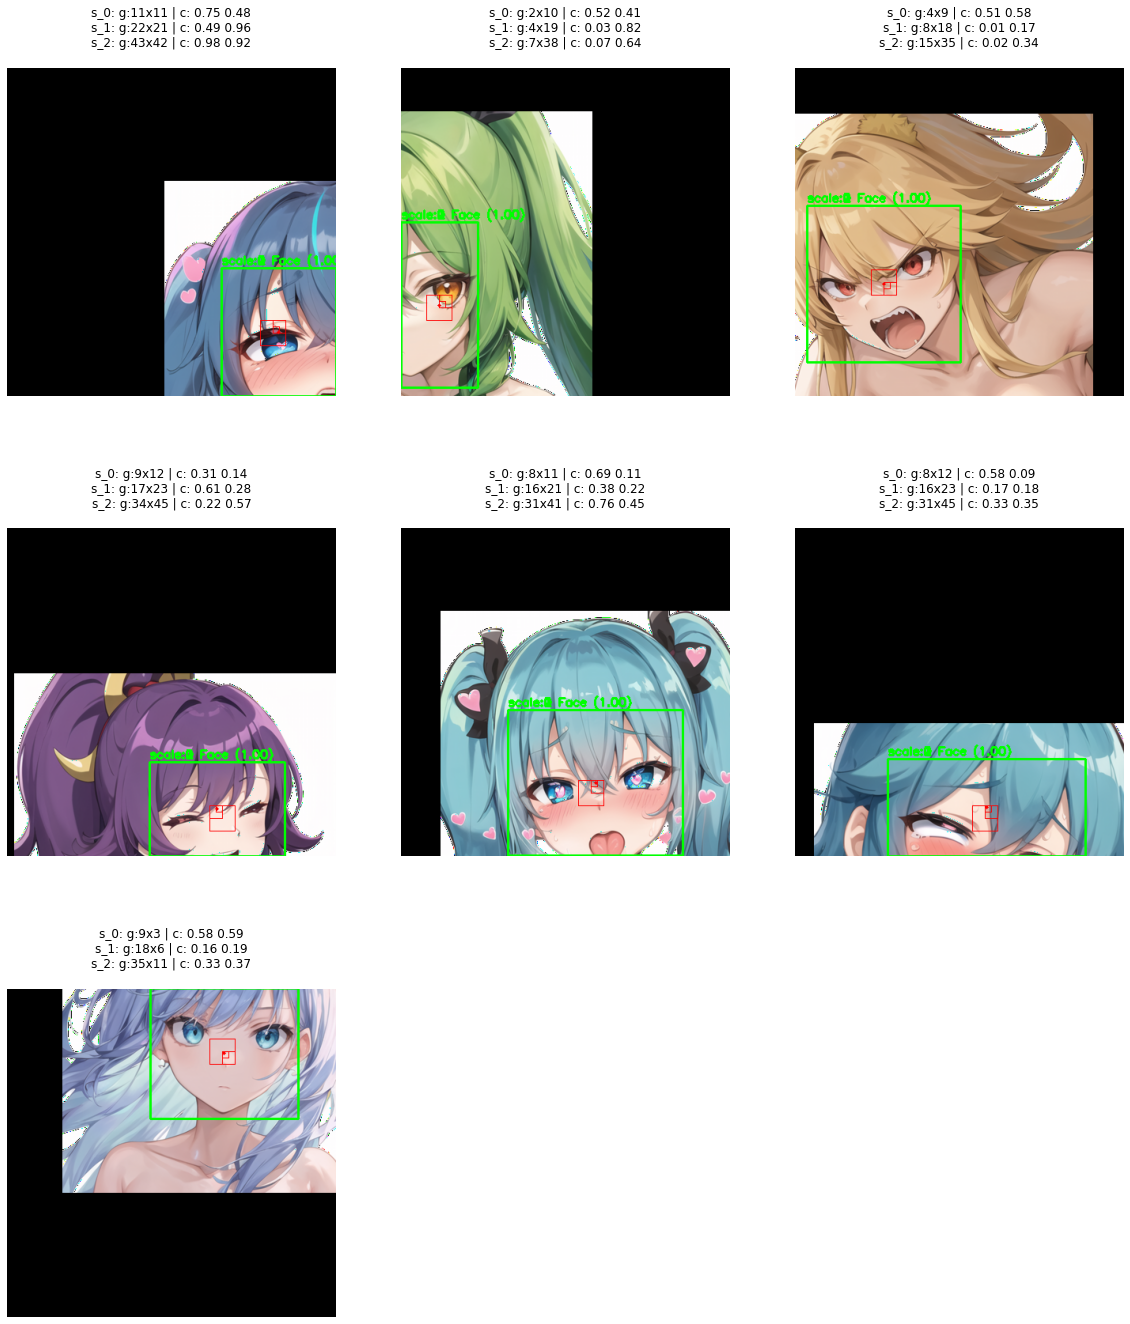

In [12]:
import math
import matplotlib.pyplot as plt

def display_batch(dataset, class_mapping, figsize=(10,10)):
    plt.figure(figsize=figsize)
    
    for images, labels in dataset.take(1):
        # Calculate number of picture
        base = 2
        while True:
            if math.log(len(images), base) <= 2:
                break   
            base += 1
        
        batch_size = images.shape[0]

        for batch_idx in range(batch_size):
            plt.subplot(base, base, batch_idx + 1)
            image = (images[batch_idx] * 255).numpy().astype("uint8")
            image_with_boxes = image.copy()
            title = ""

            for scale_idx, scale_labels in enumerate(labels):
                x_grid_size = scale_labels.shape[1]
                y_grid_size = scale_labels.shape[2]
                num_anchors = scale_labels.shape[3]

                for row in range(x_grid_size):
                    for col in range(y_grid_size):
                        for anchor_idx in range(num_anchors):
                            objectness = scale_labels[batch_idx, row, col, anchor_idx, 0]
                            
                            if objectness > 0:
                                x_center, y_center, width, height = scale_labels[batch_idx, row, col, anchor_idx, 1:5]

                                title += f"s_{scale_idx}: g:{row+1}x{col+1} | c: {x_center:.2f} {y_center:.2f}\n"

                                class_probs = scale_labels[batch_idx, row, col, anchor_idx, 5:]

                                # Convert grid cell coordinates to image coordinates
                                x_center_image = (row + x_center) * image.shape[1] / x_grid_size
                                y_center_image = (col + y_center) * image.shape[0] / y_grid_size
                                width_image = width * image.shape[1]
                                height_image = height * image.shape[0]

                                # Calculate bounding box coordinates
                                x_min = int(x_center_image - width_image / 2)
                                y_min = int(y_center_image - height_image / 2)
                                x_max = int(x_center_image + width_image / 2)
                                y_max = int(y_center_image + height_image / 2)

                                # Draw bounding box on the image
                                class_id = np.argmax(class_probs)
                                class_name = class_mapping[class_id] if class_mapping else str(class_id)
                                label = f"scale:{scale_idx} {class_name} ({objectness:.2f})"
                                color = (0, 255, 0)  # Green for the bounding box color
                                thickness = 2

                                cv2.rectangle(image_with_boxes, (x_min, y_min), (x_max, y_max), color, thickness)
                                cv2.putText(image_with_boxes, label, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, thickness)

                                """
                                # Draw grid lines
                                grid_color = (0, 0, 255)  # Red for grid lines
                                grid_thickness = 1
                                cell_width = image.shape[1] // y_grid_size
                                cell_height = image.shape[0] // x_grid_size

                                # Draw vertical grid lines
                                for i in range(1, y_grid_size):
                                    x = i * cell_width
                                    cv2.line(image_with_boxes, (x, 0), (x, image.shape[0]), grid_color, grid_thickness)

                                # Draw horizontal grid lines
                                for i in range(1, x_grid_size):
                                    y = i * cell_height
                                    cv2.line(image_with_boxes, (0, y), (image.shape[1], y), grid_color, grid_thickness)
                                """
                                    
                                # Highlight the grid cell by drawing a rectangle
                                grid_color = (255, 0, 0)  # Red for grid lines
                                grid_thickness = 1
                                cell_width = image.shape[1] // y_grid_size
                                cell_height = image.shape[0] // x_grid_size
                                
                                x_min = row * cell_width
                                y_min = col * cell_height
                                x_max = (row + 1) * cell_width
                                y_max = (col + 1) * cell_height
                                
                                cv2.rectangle(image_with_boxes, (x_min, y_min), (x_max, y_max), grid_color, grid_thickness)

                                # Draw dots at x_center and y_center
                                dot_radius = 2
                                dot_color = (255, 0, 0)  # Blue for dots
                                x_center_pixel = int(x_center_image)
                                y_center_pixel = int(y_center_image)

                                cv2.circle(image_with_boxes, (x_center_pixel, y_center_pixel), dot_radius, dot_color, -1)

            plt.imshow(image_with_boxes)
            plt.title(title)
            plt.axis("off")                        
    
        plt.show()
    


display_batch(data_generator.dataset, class_mapping=class_map, figsize=(20,24))